# <center>Xgboost GridSearch: eval logloss

In [1]:
import os
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta

In [3]:
# import warnings
# warnings.simplefilter('ignore')

pd.set_option('display.max_columns', 500)

In [4]:
data_path = Path("data")
model_path = Path("model_data")

### data

In [5]:
example_predictions_name = "example_predictions.pkl"
test_features_name = "test_features.pkl"
train_features_name = "train_features.pkl"
train_outcomes_name = "train_outcomes.pkl"

In [6]:
example_predictions = pd.read_pickle(data_path / example_predictions_name)

In [7]:
test_features = pd.read_pickle(data_path / test_features_name)
train_features = pd.read_pickle(data_path / train_features_name)
train_outcomes = pd.read_pickle(data_path / train_outcomes_name)

In [8]:
test_features.shape, train_features.shape, train_outcomes.shape

((627908, 32), (2106808, 32), (2106808, 1))

In [9]:
from dataprocessing.process import StandardScaler, SmartLogtransformer, TrainTestSplit, Pipeline
from dataprocessing.impute import SimpleImputer

In [10]:
train_test_split = TrainTestSplit(test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(train_features, train_outcomes)

### Pipeline for data processing

In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")), 
        ("logtransformer", SmartLogtransformer()), 
        ("scaler", StandardScaler())
    ]
)
pipe

[(imputer, <dataprocessing.impute.SimpleImputer>), 
(logtransformer, <dataprocessing.process.SmartLogtransformer>), 
(scaler, <dataprocessing.process.StandardScaler>)]

In [12]:
%%time
X_train = pipe.fit_transform(X_train)
X_val = pipe.transform(X_val)
X_test = pipe.transform(test_features)

Wall time: 5.25 s


## <center>XGBOOST

# <center>Parameters Tuning

## GridSearchXgb

In [13]:
import xgboost as xgb

#### Setting Parameters

In [14]:
from dataprocessing.process import GridSearchXgb

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [16]:
evals = [(dtrain, 'train'), (dval, 'eval')]

In [17]:
params = dict(
    objective = 'binary:logistic', 
    eval_metric = 'logloss'
)

In [18]:
xgb_train_params = dict(
    params = params, 
    dtrain = dtrain, 
    num_boost_round = 100, 
    evals = evals, 
    early_stopping_rounds=3, 
    verbose_eval=False
)

In [19]:
param_grid_total = dict(
    eta = [0.01, 0.05, 0.1, 0.5, 1, 2, 3],
    max_depth = range(3, 10),
    min_child_weight = range(1, 8), 
    subsample = [0.5, 1], 
    colsample_bytree = [0.5, 1], 
    alpha = [0.3, 0.65, 1]
)

In [20]:
def params_tunning(param_grid_total):
    for param in param_grid_total:
        param_grid = {param: param_grid_total[param]}
        search = GridSearchXgb(
            xgb_train_params = xgb_train_params,
            param_grid = param_grid,
        )
        search.fit()
        print(f"best_params: {search.best_params_}, best score: {search.best_score_}, best num round: {search.best_num_boost_round}")
        # set params
        for key in search.best_params_:
            params[key] = search.best_params_[key]
    return search.best_score_, params

In [22]:
%%time
best_score, best_params = params_tunning(param_grid_total)

best_params: {'eta': 0.05}, best score: 0.669052, best num round: 78
best_params: {'max_depth': 6}, best score: 0.669052, best num round: 78
best_params: {'min_child_weight': 7}, best score: 0.669034, best num round: 80
best_params: {'subsample': 1}, best score: 0.669034, best num round: 80
best_params: {'colsample_bytree': 0.5}, best score: 0.6686, best num round: 81
best_params: {'alpha': 0.65}, best score: 0.6688, best num round: 86
Wall time: 1h 14min 5s


In [23]:
print("best logloss:", best_score)

best logloss: 0.6688


In [24]:
best_params

{'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'eta': 0.05,
 'max_depth': 6,
 'min_child_weight': 7,
 'subsample': 1,
 'colsample_bytree': 0.5,
 'alpha': 0.65}

In [27]:
bst.best_ntree_limit

86

In [25]:
xgb_train_params["params"] = best_params

In [26]:
bst = xgb.train(**xgb_train_params)

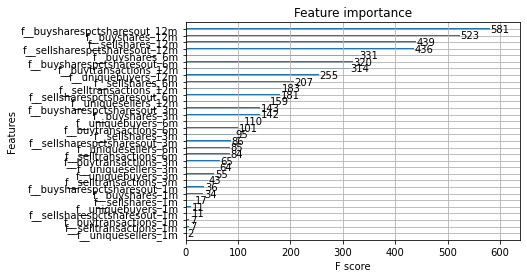

In [28]:
xgb.plot_importance(bst);

In [47]:
y_val_pred_proba = bst.predict(dval, ntree_limit=bst.best_ntree_limit)
y_val_pred_label = (y_val_pred_proba > 0.5) * 1

In [44]:
def get_acc(y_pred: np.array, y_true: pd.Series):
    tp = sum(y_pred.flatten() == y_true.values.flatten())
    return tp / len(y_true)

In [48]:
print(f"accuracy = {get_acc(y_val_pred_label, y_val)}")

accuracy = 0.5936822462886673


## <center>calibration_curve

In [46]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

In [49]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_val.values, y_val_pred_proba, n_bins=10)

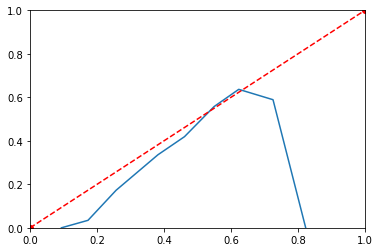

In [50]:
plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot(range(0, 2), range(0, 2), 'ro--')
plt.xlim(0, 1)
plt.ylim(0, 1);

In [52]:
print("Brier score losses: (the smaller the better)")
clf_brier_score = brier_score_loss(y_val.values, y_val_pred_proba)
print("No calibration: %1.3f" % clf_brier_score)

Brier score losses: (the smaller the better)
No calibration: 0.238


### Calibrating of Classifier
(CalibratedClassifierCV)

In [53]:
best_params

{'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'eta': 0.05,
 'max_depth': 6,
 'min_child_weight': 7,
 'subsample': 1,
 'colsample_bytree': 0.5,
 'alpha': 0.65}

In [55]:
clf = xgb.XGBClassifier(use_label_encoder=False, n_estimators=bst.best_ntree_limit, **best_params)
clf.fit(X_train.values, y_train.values.ravel())

XGBClassifier(alpha=0.65, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.05,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=0, max_depth=6, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=86, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0.649999976,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [56]:
calibrated_clf = CalibratedClassifierCV(base_estimator=clf, cv="prefit", method='isotonic')

In [57]:
calibrated_clf.fit(X_val.values, y_val.values)

CalibratedClassifierCV(base_estimator=XGBClassifier(alpha=0.65, base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.5,
                                                    eta=0.05,
                                                    eval_metric='logloss',
                                                    gamma=0, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints='',
                                                    learning_rate=0.0500000007,
                                                    max_delta_step=0,
                                                    max_depth=6,
                                                   

In [60]:
print(f"calibrated accuracy: {calibrated_clf.score(X_val, y_val)}")

calibrated accuracy: 0.5959011594489609


In [61]:
y_val_proba_clbr = calibrated_clf.predict_proba(X_val.values)

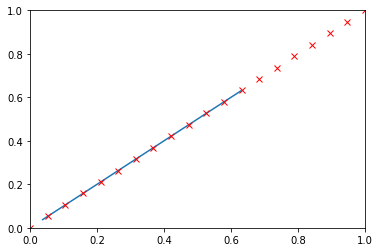

In [62]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_val.values, y_val_proba_clbr[:, 1], n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives)
plt.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), 'rx')
plt.xlim(0, 1)
plt.ylim(0, 1);

In [63]:
clf_brier_score = brier_score_loss(y_val.values, y_val_proba_clbr[:, 1])
print("Isotonic calibration: %1.3f" % clf_brier_score)

Isotonic calibration: 0.237


## Submit

In [64]:
def make_submit(sk_clf, test_features, pipe, col_name="g__12m_binary"):
    X_test = pipe.transform(test_features)
    y_test_proba = sk_clf.predict_proba(X_test.values)
    df_y_test_proba = pd.DataFrame({col_name: y_test_proba[:, 1]}, index=X_test.index)
    return df_y_test_proba

In [65]:
test_xgb_submit = make_submit(calibrated_clf, test_features, pipe)

In [66]:
test_xgb_submit

g__12m_binary
date       tradingitemid               
2016-01-01 2585893             0.594752
           2585895             0.564853
           2586016             0.621625
           2586068             0.442497
           2586084             0.564853
...                                 ...
2019-09-20 633841867           0.324344
           634751265           0.355900
           635766194           0.355900
           636344928           0.355900
           637117468           0.355900

[627908 rows x 1 columns]

In [67]:
test_xgb_submit.to_pickle(data_path / "test_xgb_submit_logloss.pkl")

#### save-read check

In [68]:
test_xgb_submit_ = pd.read_pickle(data_path / "test_xgb_submit_logloss.pkl")
assert (test_xgb_submit_ == test_xgb_submit).all().item()

In [70]:
# example_predictions